Ideas:  
- How many questions do we require a student to do before we can get an assessment on his ability? 

Modelling Approach: 
- for each student, split observations into train / test data. Earlier observations will be used to train the model to predict the student's performance in the later exercises. 

Weaknesses / Assumptions:
- assumes that students' behaviour is static and will continue beyond the duration of the training data 
- assumes that all topics / chapters are of the same difficulty (eg. calculus is as challenging as linear algebra). we do control for the difficulty of the exercise as tagged in info_content.

In [1]:
import pandas as pd 
import numpy as np 
import re  
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import datetime as dt

preload = True

In [2]:
# %% load data
data_dir = r'C:\Users\Timothy Lim\Desktop\junyi\archive'
info_content = pd.read_csv(os.path.join(data_dir, 'Info_Content.csv'))
info_userdata = pd.read_csv(os.path.join(data_dir, 'Info_UserData.csv'))
log_problem = pd.read_csv(os.path.join(data_dir, 'Log_Problem.csv'))

log_problem['timestamp_TW'] = log_problem['timestamp_TW'].apply(lambda x: dt.datetime.strptime(x[:-4], "%Y-%m-%d %H:%M:%S"))
log_problem.sort_values(by='timestamp_TW', ascending=True, inplace=True)
log_problem.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
105021,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,9Ksy3bdm0HTi0D+cdKSBKDQJjo5GNahep91FqHUrpts=,2,1,True,8,1,0,False,NaN,NaN,0
11669798,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,/Wgjdl2BsldHZDdXXvzwGimusaMX548lqV2b7PgwXAs=,1,1,True,10,1,0,False,NaN,NaN,0
3768239,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,vsGlLPd9C58B8myBoGMGre2pDHjh62eRjsqX57D98fU=,5,1,True,6,1,0,False,False,True,1
10163558,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,hv7kHCAIdj7thZUmlqz553leG5bFNYgzXmLfB5m4Xvw=,h3CI/U4QJd6mjYE5xRH8QEst8lRG7otYIz+q1V6Och4=,5,1,True,5,1,0,False,False,True,1
8372688,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OSuDd4rDo2muXXwwJRU2DQVHkk6/JOGgNzfzNi4PMJM=,3,1,True,4,1,0,False,NaN,NaN,0


In [3]:
info_content.head()

,ucid,content_pretty_name,content_kind,difficulty,subject,learning_stage,level1_id,level2_id,level3_id,level4_id
0,odIwFdIiecFwVUAEEV40K3MSuCSlIZkbq92Zp9tkZq8=,【基礎】怎樣解題：數量關係,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
1,dfeeBaa8zDhWS6nu7zeXKwLyi4zqEajI3tJM9/fSBPM=,【基礎】和差問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
2,C2AT0OBTUn+PRxEVd39enhW/DJtka1Tk90DUAR6yVdA=,【基礎】雞兔問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
3,jZvYpEa6VB/WrlKKmQHnfbv/xJ4OypBzq0epVcn500Q=,【基礎】年齡問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
4,M+UxJPgRIW57a0YS3eik8A9YDj+AwaMpTa5yWYn/kAw=,【基礎】追趕問題,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=


<AxesSubplot:>

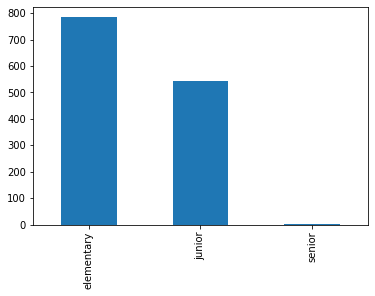

In [4]:
info_content['learning_stage'].value_counts().plot(kind='bar')

<AxesSubplot:>

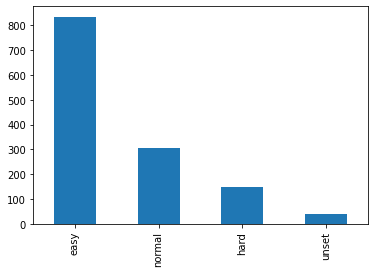

In [5]:
info_content['difficulty'].value_counts().plot(kind='bar')

In [6]:
info_userdata.head()

,uuid,gender,points,badges_cnt,first_login_date_TW,user_grade,user_city,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt
0,Y2RcCdmUJAYPUAIDElo4nE9KrkLLFzUIRdexG+ipaZQ=,NaN,18300,1,2019-01-24,1,kh,0,False,0,0,0
1,lw/Rchfvl9q1UDaQRmeE6QJDJeXAK7nt56RvUvqxD/8=,NaN,6468,0,2019-01-24,1,ntpc,1,False,0,1,0
2,ncVYyCw3osV77X9M+4NbI7LvBR5UiB4ix6Ca+baQArA=,male,4703,0,2019-01-24,1,tp,0,False,0,0,0
3,J7Tbo1x2WtRpPuXeX7lWT9tkzWlSJeubl8UWjNmHh+4=,NaN,15525,1,2019-01-24,2,ntpc,0,False,0,0,0
4,qijKzROzz1LmCaCxHJ3mOBOtjW/q4kW80tnpPmXHVYQ=,NaN,7945,0,2019-01-24,2,km,1,False,0,1,0


From info_userdata, it wouldn't be appropriate to use most of these columns as it is likely that they are a function of the students' correctness.  

Might include things such as user_grade and is_self_coach. 

### Data Wrangling

- sort the train / test split. for each user, split the observations from log_problem into 70-30 for training and validation data. 

In [7]:
log_problem.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
105021,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,9Ksy3bdm0HTi0D+cdKSBKDQJjo5GNahep91FqHUrpts=,2,1,True,8,1,0,False,NaN,NaN,0
11669798,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,/Wgjdl2BsldHZDdXXvzwGimusaMX548lqV2b7PgwXAs=,1,1,True,10,1,0,False,NaN,NaN,0
3768239,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,vsGlLPd9C58B8myBoGMGre2pDHjh62eRjsqX57D98fU=,5,1,True,6,1,0,False,False,True,1
10163558,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,hv7kHCAIdj7thZUmlqz553leG5bFNYgzXmLfB5m4Xvw=,h3CI/U4QJd6mjYE5xRH8QEst8lRG7otYIz+q1V6Och4=,5,1,True,5,1,0,False,False,True,1
8372688,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OSuDd4rDo2muXXwwJRU2DQVHkk6/JOGgNzfzNi4PMJM=,3,1,True,4,1,0,False,NaN,NaN,0


In [8]:
# group obserations by uuid, sort by ucid, problem_number and timestamp_TW

user_logs = log_problem.groupby(by='uuid')
user_logs

In [9]:
# test case

test_userid = 'U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4='
test_user = user_logs.get_group(test_userid).sort_values(by=['timestamp_TW', 'ucid', 'problem_number'], ascending=True)
test_user

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
11669798,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,/Wgjdl2BsldHZDdXXvzwGimusaMX548lqV2b7PgwXAs=,1,1,True,10,1,0,False,NaN,NaN,0
105021,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,9Ksy3bdm0HTi0D+cdKSBKDQJjo5GNahep91FqHUrpts=,2,1,True,8,1,0,False,NaN,NaN,0
8372688,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OSuDd4rDo2muXXwwJRU2DQVHkk6/JOGgNzfzNi4PMJM=,3,1,True,4,1,0,False,NaN,NaN,0
13311409,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,OE6ac/KSBYPUdQIN5KjVZS1QSxWiKqis6mIYB0s6kV4=,4,1,True,7,1,0,False,NaN,NaN,0
3768239,2018-08-01 07:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,vsGlLPd9C58B8myBoGMGre2pDHjh62eRjsqX57D98fU=,5,1,True,6,1,0,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7699120,2019-02-09 18:15:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,l2qnFsTkIC5rtckJOSRUU9Fa26UjskhobzBBg0ZOQsM=,d3xxDFkFvlEa9UW4LRjJueNzOHv0gmhLQYhb3w1bpeE=,24,2,True,10,1,0,False,NaN,NaN,1
14647520,2019-02-09 18:15:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,l2qnFsTkIC5rtckJOSRUU9Fa26UjskhobzBBg0ZOQsM=,rp1F9dmqyQZgTFBHfD9u8h3ha8HuuWG0w1X4ef4BoTY=,25,2,True,31,1,0,False,NaN,NaN,1
9214797,2019-02-09 18:15:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,l2qnFsTkIC5rtckJOSRUU9Fa26UjskhobzBBg0ZOQsM=,oOak/uloxaP6ii/nCSweplg8TInCDg/QZK22Bub9c8U=,26,2,False,45,2,1,True,NaN,NaN,1
7596291,2019-02-09 18:45:00,U+lqK/FKWkPuoNUM1AbGyrKZfXeQrRRoKOToKrjqDt4=,GhFxv7BoAI++BrgjSP6mVEhEsO33gLRvb66hG7WW6iA=,QiMXL233FLU1VSqbXsKo1/YWXzwLVn+Yc6QoH7lilqs=,1,1,True,50,1,0,False,NaN,NaN,0


In [10]:
# check if there are any overlap in content

content_ids = test_user['ucid'].unique()

time_dict = {}
for content_id in content_ids:
    tmp = test_user[test_user['ucid']==content_id]
    
    min_time = tmp['timestamp_TW'].min()
    max_time = tmp['timestamp_TW'].max()
    
    time_dict[content_id] = (min_time, max_time)



for k, v in time_dict.items():
    min_time = v[0]
    max_time = v[1]
    
    for k2, v2 in time_dict.items():
        # check if min time is smaller, and max time is bigger
        if min_time < v2[0] and max_time > v2[1]: 
            print (k, k2)

1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo= TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=
1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo= MefOHEpHMbpSlIglmM0dFv9PLECXPNiRwF5qFmNSncA=
1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo= U6uPrXsMf01kkpbyFTf6NgLBFfypQFIdHmXH8GYZPyw=


In [11]:
# check sequence for these

content_ids = ['1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo=', 'TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=',
              'MefOHEpHMbpSlIglmM0dFv9PLECXPNiRwF5qFmNSncA=', 'U6uPrXsMf01kkpbyFTf6NgLBFfypQFIdHmXH8GYZPyw=']

test_user[test_user['ucid'].isin(content_ids)][['timestamp_TW', 'ucid', 'problem_number']]

,timestamp_TW,ucid,problem_number
3582780,2018-08-01 08:00:00,1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo=,1
6921386,2018-08-01 08:00:00,1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo=,2
15028525,2018-08-01 08:00:00,1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo=,3
8480951,2018-08-01 08:00:00,1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo=,4
6626019,2018-08-01 08:00:00,1rYu966l6i1cA34mdxukVKusuaDPMwcW6a6WCWe5ZFo=,5
10049056,2018-08-02 07:45:00,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,1
11723360,2018-08-02 07:45:00,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,2
248029,2018-08-02 08:00:00,MefOHEpHMbpSlIglmM0dFv9PLECXPNiRwF5qFmNSncA=,1
353881,2018-08-02 08:00:00,MefOHEpHMbpSlIglmM0dFv9PLECXPNiRwF5qFmNSncA=,2
319643,2018-08-02 08:00:00,MefOHEpHMbpSlIglmM0dFv9PLECXPNiRwF5qFmNSncA=,3


Using this as an example, the data is sorted correctly. However, it is not clear which exercises were attempted first on 2018-08-02 08:00:00.  

solution -> if same timestamp, then just take all as testing data.

In [12]:
from sklearn.model_selection import train_test_split
import progressbar

# create X and y data
X_data = {}
y_data = {}
train_size = 0.7  # for each user, use 70% of his observations to predict his performance in the remaining 30% of data avail.

users = user_logs.groups.keys()
bar = progressbar.ProgressBar(maxval=len(users), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()    
for i, user in enumerate(users):
    if preload:  # no need to preprocess features
        break 

    bar.update(i+1)
    user_data = user_logs.get_group(user)
    
    # if only 1 timestamp worth of exercises, skip
    if len(user_data['timestamp_TW'].unique()) == 1:
        continue
    
    # sort values
    user_data.sort_values(by=['timestamp_TW', 'ucid', 'problem_number'], ascending=True, inplace=True)
    
    # split data
    try:
        user_train, user_test = train_test_split(user_data, train_size=train_size, shuffle=False)
        
        # check if there is overlap in train and test timestamps
        if user_train['timestamp_TW'].max() == user_test['timestamp_TW'].min():
            idx = user_train['timestamp_TW'].idxmax()
            user_test = user_train.loc[idx:].append(user_test)
            user_train = user_train.loc[:idx][:-1]  # pandas loc slicing is inclusive
    
    except ValueError:
        user_train = user_data
        user_test = pd.DataFrame([], columns=user_train.columns)  # create empty df
         
    # add to dict
    X_data[user] = user_train
    y_data[user] = user_test

bar.finish()

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[========================================================================] 100%


In [13]:
print(len(X_data))
print(len(y_data))

63342
63342


In [14]:
# peek data 

print(X_data[user].shape)
print(y_data[user].shape)

X_data[user]

(101, 14)
(73, 14)


,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
8818038,2018-10-11 16:15:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,4p305X/NqL1Zx9j6BDJEpiQx090kFF3o/LTTGJt5s/E=,twWapESr+NlCzT7vIOCy1R2DNrEbaLjkjBm4NzJDe5s=,4,1,False,81,1,1,True,NaN,NaN,0
15221490,2018-10-11 16:15:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,4p305X/NqL1Zx9j6BDJEpiQx090kFF3o/LTTGJt5s/E=,OJQd0wnJm6hXWovyHipFGk3Y3xEGmrNhrDlaintgI8Y=,5,1,True,81,1,0,False,NaN,NaN,0
6705314,2018-10-11 16:15:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,4p305X/NqL1Zx9j6BDJEpiQx090kFF3o/LTTGJt5s/E=,WpLmBz31ujLqDg068Bk/74ovvE97d2fDg5S9f8+auhE=,6,1,False,26,1,1,True,NaN,NaN,0
9031507,2018-10-11 16:15:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,4p305X/NqL1Zx9j6BDJEpiQx090kFF3o/LTTGJt5s/E=,c1SMSROr5nekNBrLgNn3KhYFw9FIXE98Qx+vvpeIZes=,7,1,True,18,1,0,False,NaN,NaN,0
625467,2018-10-11 16:15:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,4p305X/NqL1Zx9j6BDJEpiQx090kFF3o/LTTGJt5s/E=,OyxYNZNyji9G6iqmgNAuwEv38Wh53N+IJ9WtRE5hAy8=,8,1,True,42,1,0,False,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172766,2019-03-11 15:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,Iri0Mm69Jhy9dYumaZScJt7B6cHJhAjve5Ii96kP4vc=,wtwIkwTxNScsqAZDAVp71cNTcG7VpPtvf7iy7wXI+78=,26,3,True,3,1,0,False,NaN,NaN,1
14250465,2019-03-11 15:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,Iri0Mm69Jhy9dYumaZScJt7B6cHJhAjve5Ii96kP4vc=,PA7xhLXiW3MxX1FMMWEDh6Nu3hzWY5S1hcszx55Yypc=,27,5,True,2,1,0,False,NaN,NaN,1
1054399,2019-03-11 15:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,PB+tEauJ6Cu8clF5IHjouv5FqEgH9UDWxbOqE+SBa50=,KoSG7qHimV8YMh8x5fISPIx8b5IRTMoFLh9nph2yXGU=,1,1,True,79,1,0,False,NaN,NaN,0
14268803,2019-03-25 15:15:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,8OlykxhWhqdmoDYEhKD8tSEmLYicz/JYI4slzcjyUpU=,17,1,False,0,0,3,True,NaN,NaN,3


In [15]:
y_data[user]

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
15645667,2019-03-25 15:30:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,aYVKpPtEEpXlTwg1bkPFEsmz4mD+/bLosUgO5EVas8g=,18,1,False,31,1,3,True,NaN,NaN,3
9184855,2019-03-25 15:30:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,/JNuBvIEFAn2uEvBJQ2/pZtjPxiaWBlt1eeX3GbPBpo=,19,1,True,15,1,0,False,NaN,NaN,3
14248022,2019-03-25 15:30:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,0EXI7sXRLGCZ+1VDHgSsXsly1OlEi9WHEF8TaMzya4s=,20,1,False,202,3,0,False,NaN,NaN,3
12550913,2019-03-25 15:30:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,Kz0fMxzSvomGTcT6cnhLhMWdWclGYtFKR7ZH7P6QUOc=,21,2,True,61,1,0,False,NaN,NaN,3
15789855,2019-03-25 15:30:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,5Klyzz2Ms15M4vnwEF3gUtWhATyaXAqMGRoFFPYYviY=,22,1,False,26,4,1,True,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11313164,2019-05-27 15:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,Iri0Mm69Jhy9dYumaZScJt7B6cHJhAjve5Ii96kP4vc=,PA7xhLXiW3MxX1FMMWEDh6Nu3hzWY5S1hcszx55Yypc=,67,10,False,8,4,1,True,NaN,NaN,3
6238362,2019-05-27 15:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,Iri0Mm69Jhy9dYumaZScJt7B6cHJhAjve5Ii96kP4vc=,xOn6NF4t13Mh4VPFtEWXTzR2nOoXCh6g49k4NGQSh5U=,68,9,True,4,1,0,False,NaN,NaN,3
14326843,2019-05-27 15:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,Iri0Mm69Jhy9dYumaZScJt7B6cHJhAjve5Ii96kP4vc=,wNlBN4yfjAIV6+u2c3GdpdAyoT+bp1PsJIY5cn8lPq4=,69,12,True,5,1,0,False,False,True,4
4698428,2019-05-29 11:45:00,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,pHm5o9NLjlO2lXB7CH2U80qF20rcHwHgxaIwnQiSd/c=,1I+S7lx0bkpcQObIQUO1MZubkz1jsl5o2TfTkqZbFS4=,1,1,True,36,1,0,False,NaN,NaN,0


In [16]:
info_userdata.columns

Index(['uuid', 'gender', 'points', 'badges_cnt', 'first_login_date_TW',
       'user_grade', 'user_city', 'has_teacher_cnt', 'is_self_coach',
       'has_student_cnt', 'belongs_to_class_cnt', 'has_class_cnt'],
      dtype='object')

In [17]:
info_content.columns

Index(['ucid', 'content_pretty_name', 'content_kind', 'difficulty', 'subject',
       'learning_stage', 'level1_id', 'level2_id', 'level3_id', 'level4_id'],
      dtype='object')

For each user, we want to generate the following features: 
- no. of unique ucid attempted 
- no. of repeated upid (will be related to accuracy) 
- avg accuracy, total_sec_taken
- no. of upgrades (only count True values)
- no. of downgrades (only count True values) 

from info_content:
- no. of content at each learning stage 
- no. of easy / hard / normal / unset difficulty level problems 

from info_userdata: 
- user_grade
- is_self_coach

please feel free help me think of more features :DDD

### Feature Engineering

In [18]:
import pickle

def save_file(obj, path_name):
    with open(path_name, 'wb') as handle:
        pickle.dump(obj, handle)

def load_file(path_name):
    with open(path_name, 'rb') as handle:
        return pickle.load(handle)
    

# test
something = 'abc'
save_file(something, 'something.pickle')
assert(load_file('something.pickle') == something)

In [19]:
# for each user, generate the features

def get_ls_counts(value_counts, ls):
    try:
        counts = value_counts.loc[ls]
    except KeyError:
        counts = 0
    return counts
    
def gen_features(data_dict):
    bar = progressbar.ProgressBar(maxval=len(X_data), 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    bar.start()

    i = 0
    for user, user_data in data_dict.items():
        bar.update(i+1)
        
        # merge with info_content
        user_data = user_data.merge(info_content[['ucid', 'difficulty', 'learning_stage']], how='left', on='ucid')
        
        # from log problem
        n_ucid = len(user_data['ucid'].unique())
        n_repeated_upid = sum(user_data['upid'].value_counts() > 1)
        avg_acc = user_data['is_correct'].mean()
        avg_sec_taken = user_data['total_sec_taken'].mean()
        n_upgrades = user_data['is_upgrade'].sum()
        n_downgrades = user_data['is_downgrade'].sum()
        
        # from info_content
        ls_counts = user_data['learning_stage'].value_counts()
        
        n_elementary = get_ls_counts(ls_counts, 'elementary')
        n_junior = get_ls_counts(ls_counts, 'junior')
        n_senior = get_ls_counts(ls_counts, 'senior')
        
        # from info_userdata
        user_grade = info_userdata.loc[info_userdata['uuid']==user]['user_grade'].values[0]
        user_self_coach = info_userdata.loc[info_userdata['uuid']==user]['is_self_coach'].values[0]
        
        # update the dict
        data_dict[user] = [n_ucid, n_repeated_upid, avg_acc, avg_sec_taken, n_upgrades, n_downgrades,
                           n_elementary, n_junior, n_senior, user_grade, user_self_coach]
        i += 1
        
    bar.finish()

In [20]:
# generate features for input data
if not preload:
    gen_features(X_data)
    
    # for y data, just need to get the avg accuracy
    for user, user_data in y_data.items():
        avg_acc = user_data['is_correct'].mean()
        y_data[user] = avg_acc
    
    # create final dataframe for model
    final_df = pd.DataFrame.from_dict(X_data, orient='index')
    final_df.columns = ['n_ucid', 'n_repeated_upid', 'avg_acc', 'avg_sec_taken', 'n_upgrades',
                       'n_downgrades', 'n_elementary', 'n_junior', 'n_senior', 'user_grade', 'user_self_coach']
    
    # merge with student avg acc 
    avg_acc_series = pd.Series(y_data)
    avg_acc_series.name = 'avg_acc'
    final_df = final_df.merge(avg_acc_series, how='inner', left_index=True, right_index=True)
    
    # rename columns
    final_df.rename(columns={'avg_acc_x': 'curr_avg_acc', 'avg_acc_y': 'future_avg_acc'}, inplace=True)
    
    # bin future avg acc 
    final_df['future_avg_acc_binned'] = pd.qcut(final_df['future_avg_acc'], 3, labels=['weak', 'average', 'strong'])
    final_df['future_avg_acc_binned'].value_counts(normalize=True)
    
    save_file(final_df, 'final_df.pickle')

else:
    # read pickle file
    final_df = load_file('final_df.pickle')

[========================================================================] 100%


NameError: name 'avg_acc_series' is not defined

In [24]:
final_df[final_df['future_avg_acc_binned']=='weak']['future_avg_acc'].max()

0.6630434782608695

In [25]:
final_df[final_df['future_avg_acc_binned']=='average']['future_avg_acc'].max()

0.8260869565217391

In [26]:
final_df[final_df['future_avg_acc_binned']=='strong']['future_avg_acc'].max()

1.0

In [27]:
final_df.isna().sum()

n_ucid                      0
n_repeated_upid             0
curr_avg_acc             2188
avg_sec_taken            2188
n_upgrades                  0
n_downgrades                0
n_elementary                0
n_junior                    0
n_senior                    0
user_grade                  0
user_self_coach             0
future_avg_acc              0
future_avg_acc_binned       0
dtype: int64

### Modelling

In [28]:
final_df.dropna(subset=['future_avg_acc_binned'], inplace=True)
train_data, test_data = train_test_split(final_df, test_size=0.3, random_state=12345)
print(train_data.shape)
print(test_data.shape)

(44339, 13)
(19003, 13)


In [29]:
train_data.head()

,n_ucid,n_repeated_upid,curr_avg_acc,avg_sec_taken,n_upgrades,n_downgrades,n_elementary,n_junior,n_senior,user_grade,user_self_coach,future_avg_acc,future_avg_acc_binned
/6Y8YBJr1hJnGoercYOIpWZ6fgn0EgEZlaRN4sTOPTA=,22,5,0.909639,30.277108,37,0,166,0,0,3,False,0.946667,strong
o7dphdTBYWzUArKH7PzA3duPRShLNZ+3bseo69P7QZ8=,8,6,0.750000,55.468750,4,0,32,0,0,5,False,0.833333,strong
P8JBBGJ+Y6MiustkMgGeuNJvwT5TiQFZRZfJAo5lW9M=,7,0,0.942857,6.857143,6,0,35,0,0,7,False,1.000000,strong
w+9jIi2FP63gANyhsibs1hnVSn0ZcGlUKnKQgQTTqU8=,1,0,0.000000,32.000000,0,0,0,1,0,7,False,1.000000,strong
+B2V2ESExjRZ34ldMzUJsOWw+x80fx1gMQg9BXgBupk=,10,0,0.774648,44.281690,8,0,71,0,0,6,False,0.777778,average


In [30]:
X_train = train_data.drop(columns=['future_avg_acc_binned', 'future_avg_acc'])
X_test = test_data.drop(columns=['future_avg_acc_binned', 'future_avg_acc'])

y_train = train_data['future_avg_acc_binned']
y_test = test_data['future_avg_acc_binned']

y_train.value_counts(normalize=True)

average    0.335123
weak       0.333025
strong     0.331852
Name: future_avg_acc_binned, dtype: float64

In [31]:
y_test.value_counts(normalize=True)

strong     0.336210
weak       0.334053
average    0.329737
Name: future_avg_acc_binned, dtype: float64

### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

X_train_dropna = X_train.dropna(how='any')
lr_clf = LogisticRegression(random_state=12345)

lr_clf.fit(X_train.fillna(0), y_train)
lr_pred = lr_clf.predict(X_test.fillna(0))

# lr_clf.fit(X_train_dropna, y_train[X_train_dropna.index])
# lr_pred = lr_clf.predict(X_test.dropna(how='any'))

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Text(0, 0.5, 'average'), Text(0, 1.5, 'strong'), Text(0, 2.5, 'weak')]

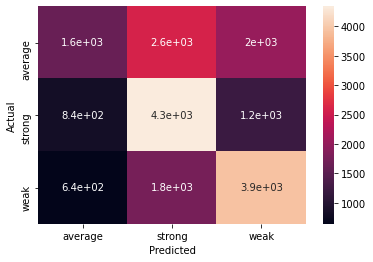

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pred, labels=lr_clf.classes_)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.xaxis.set_ticklabels(lr_clf.classes_)
ax.yaxis.set_ticklabels(lr_clf.classes_)

In [35]:
from sklearn.metrics import classification_report

clf_report = classification_report(y_test, lr_pred, target_names=lr_clf.classes_, output_dict=False)
print(clf_report)

              precision    recall  f1-score   support

     average       0.52      0.26      0.35      6266
      strong       0.50      0.68      0.58      6389
        weak       0.55      0.62      0.58      6348

    accuracy                           0.52     19003
   macro avg       0.52      0.52      0.50     19003
weighted avg       0.52      0.52      0.50     19003



### XGBoost

obviously performs much better than logistic regression.

In [36]:
from xgboost import XGBClassifier

# fit with default params
xgb_clf = XGBClassifier(objective='multi:softmax',
                       num_class=3,
                       random_state=12345)

xgb_clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['merror', 'mlogloss'], 
            verbose=True)

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.42437	validation_0-mlogloss:1.01836	validation_1-merror:0.42409	validation_1-mlogloss:1.01895
[1]	validation_0-merror:0.42297	validation_0-mlogloss:0.96960	validation_1-merror:0.42388	validation_1-mlogloss:0.97139
[2]	validation_0-merror:0.41956	validation_0-mlogloss:0.93785	validation_1-merror:0.42130	validation_1-mlogloss:0.94103
[3]	validation_0-merror:0.41909	validation_0-mlogloss:0.91636	validation_1-merror:0.42088	validation_1-mlogloss:0.92111
[4]	validation_0-merror:0.41852	validation_0-mlogloss:0.90120	validation_1-merror:0.42009	validation_1-mlogloss:0.90776
[5]	validation_0-merror:0.41706	validation_0-mlogloss:0.89030	validation_1-merror:0.42009	validation_1-mlogloss:0.89884
[6]	validation_0-merror:0.41616	validation_0-mlogloss:0.88221	validation_1-merror:0.41925	validation_1-mlogloss:0.89260
[7]	validation_0-merror:0.41557	validation_0-mlogloss:0.87593	validation_1-merror:0.41893	validation_1-mlogloss:0.88827
[8]	validation_0-merror:0.41388	validati

[68]	validation_0-merror:0.37331	validation_0-mlogloss:0.79446	validation_1-merror:0.42483	validation_1-mlogloss:0.88336
[69]	validation_0-merror:0.37254	validation_0-mlogloss:0.79321	validation_1-merror:0.42425	validation_1-mlogloss:0.88351
[70]	validation_0-merror:0.37198	validation_0-mlogloss:0.79249	validation_1-merror:0.42467	validation_1-mlogloss:0.88361
[71]	validation_0-merror:0.37150	validation_0-mlogloss:0.79159	validation_1-merror:0.42488	validation_1-mlogloss:0.88367
[72]	validation_0-merror:0.37071	validation_0-mlogloss:0.79063	validation_1-merror:0.42514	validation_1-mlogloss:0.88371
[73]	validation_0-merror:0.37051	validation_0-mlogloss:0.79010	validation_1-merror:0.42520	validation_1-mlogloss:0.88380
[74]	validation_0-merror:0.36974	validation_0-mlogloss:0.78890	validation_1-merror:0.42588	validation_1-mlogloss:0.88409
[75]	validation_0-merror:0.36897	validation_0-mlogloss:0.78792	validation_1-merror:0.42583	validation_1-mlogloss:0.88411
[76]	validation_0-merror:0.36830

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=12345, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

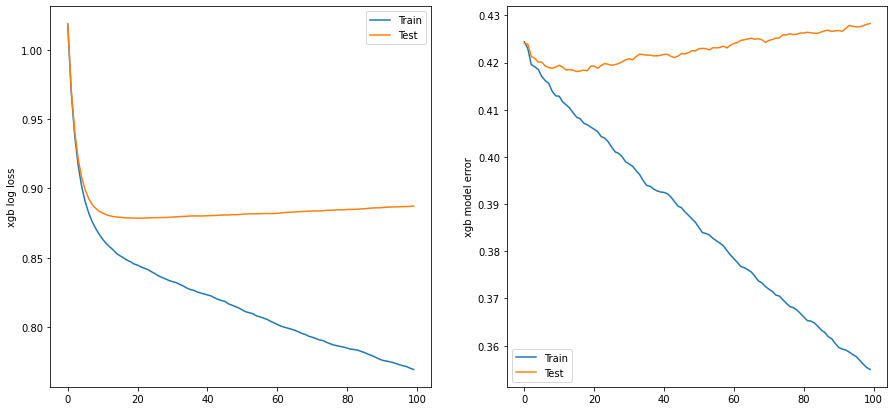

In [37]:
# eval results
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax[0].set_ylabel('xgb log loss')
ax[0].legend()


# plot clf error
ax[1].plot(x_axis, results['validation_0']['merror'], label='Train')
ax[1].plot(x_axis, results['validation_1']['merror'], label='Test')
ax[1].set_ylabel('xgb model error')
ax[1].legend()

plt.show()

Looks like the model is being overfit on the training data. 

[Text(0, 0.5, 'average'), Text(0, 1.5, 'strong'), Text(0, 2.5, 'weak')]

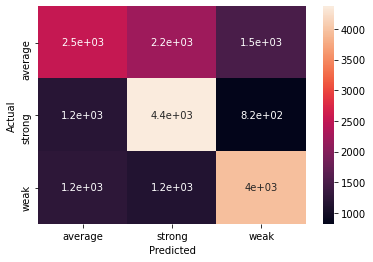

In [38]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf.classes_)

# plot
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.xaxis.set_ticklabels(xgb_clf.classes_)
ax.yaxis.set_ticklabels(xgb_clf.classes_)

In [39]:
from sklearn.metrics import classification_report

clf_report = classification_report(y_test, y_pred, target_names=xgb_clf.classes_, output_dict=False)
print(clf_report)

              precision    recall  f1-score   support

     average       0.51      0.41      0.45      6266
      strong       0.56      0.68      0.62      6389
        weak       0.63      0.62      0.63      6348

    accuracy                           0.57     19003
   macro avg       0.57      0.57      0.57     19003
weighted avg       0.57      0.57      0.57     19003



Decent performance in identifying medium/strong students. Recall for weak students is not very high, indicating that the model misses quite a few of these students. 

Overall accuracy is ok...we have 3 classes so baseline is roughly 0.33

In [40]:
# feature importance
feature_names = X_train.columns
importance_scores = zip(feature_names, xgb_clf.feature_importances_)
sorted(importance_scores, key=lambda x: x[1])[::-1]


[('curr_avg_acc', 0.38816264),
 ('n_ucid', 0.096862264),
 ('n_upgrades', 0.09616618),
 ('n_repeated_upid', 0.068714686),
 ('n_junior', 0.064627826),
 ('user_grade', 0.062305853),
 ('n_elementary', 0.056752168),
 ('avg_sec_taken', 0.053143077),
 ('user_self_coach', 0.0444183),
 ('n_downgrades', 0.035877716),
 ('n_senior', 0.032969177)]

### Post-Prediction Analysis
- how much data was collected for each student? Did it affect the accuracy of the predictions?  

In [41]:
user_count = log_problem['uuid'].value_counts()

y_pred = pd.Series(y_pred, index=X_test.index, name='y_pred')

# join with predictions and actual labels
user_count = user_count.to_frame().merge(y_pred, left_index=True, right_index=True, how='inner')
user_count = user_count.merge(y_test, left_index=True, right_index=True, how='inner')
user_count.shape

(19003, 3)

In [42]:
user_count.columns = ['value_counts', 'y_pred', 'y_true']
user_count['correct_prediction'] = np.where(user_count['y_pred']==user_count['y_true'], True, False)
user_count['correct_prediction'].value_counts(normalize=True)

True     0.571752
False    0.428248
Name: correct_prediction, dtype: float64

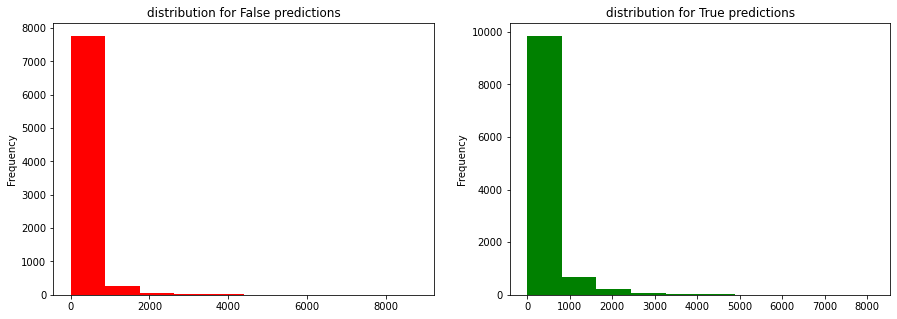

In [43]:
## is the amount of data collected different for correct / wrong predictions? no filter

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
colors = ['red', 'green']

for i in range(2):
    mask = (user_count['correct_prediction']==i)
    user_count[mask]['value_counts'].plot(kind='hist', ax=axes[i], title=f'distribution for {True==i} predictions',
                                         color=colors[i])

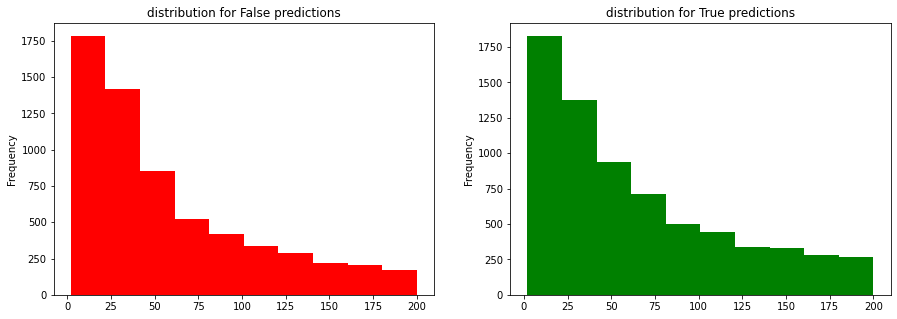

In [44]:
## is the amount of data collected different for correct / wrong predictions? filter less than 200

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
colors = ['red', 'green']

for i in range(2):
    mask = (user_count['correct_prediction']==i) & (user_count['value_counts'] <= 200)
    user_count[mask]['value_counts'].plot(kind='hist', ax=axes[i], title=f'distribution for {True==i} predictions',
                                         color=colors[i])

the amount of data collected doesn't seem to matter that much?

removed students where more than 200 observations collected so that we can see the distribution more clearly. correct observations have slightly more data collected.

### Feature Importance Analysis 
- feature importance by various measures
- SHAP values + interpretation 

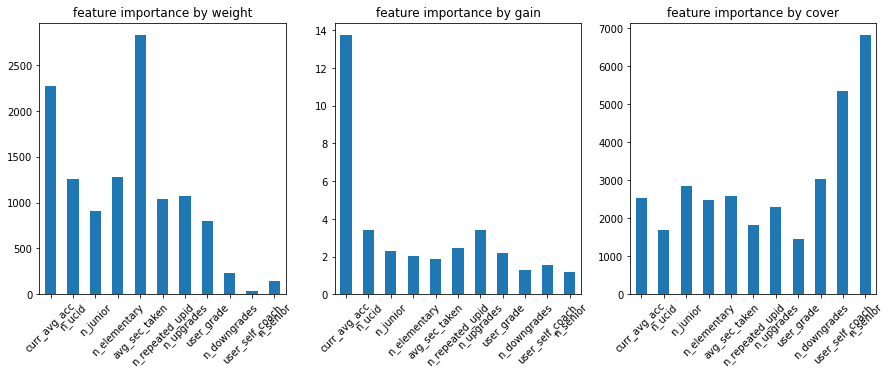

In [45]:
types = ['weight', 'gain', 'cover']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, t in enumerate(types):
    importance = xgb_clf.get_booster().get_score(importance_type=t)
    pd.Series(importance).plot(kind='bar', ax=axes[i], title=f'feature importance by {t}', rot=45)
    

weight (frequency) -> no. of times that the feature is used to split the data across all trees 

gain -> information gained from splits on this feature 

cover -> no. of times that observations are uesd related to the feature 

how do we interpret these? 

gain is probably the most relevant in understanding which features are important in getting predictions. based on this, we can see that *curr_avg_acc* is significantly more useful in getting predictions. however, this does not give us information about how these features interact with the target feature.

For that, we can use SHAP values.

In [46]:
import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

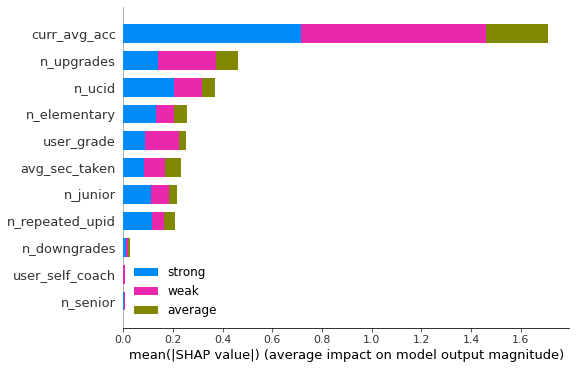

In [47]:
# overall shap summary plot
shap.summary_plot(shap_values, X_test, class_names=xgb_clf.classes_)

Bar plot is additive.

Using *curr_avg_acc* as an example, we can see that the SHAP value for classs *strong* is approximately 0.6, and SHAP value for class *weak* is 1.4-0.6 = 1.2.

Shap values for class average


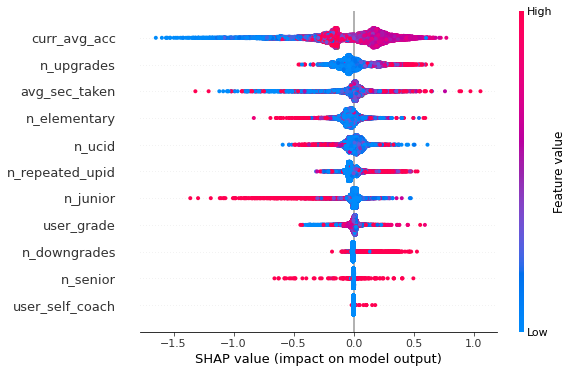

Shap values for class strong


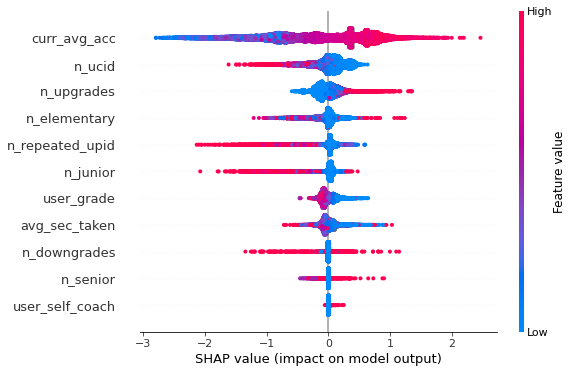

Shap values for class weak


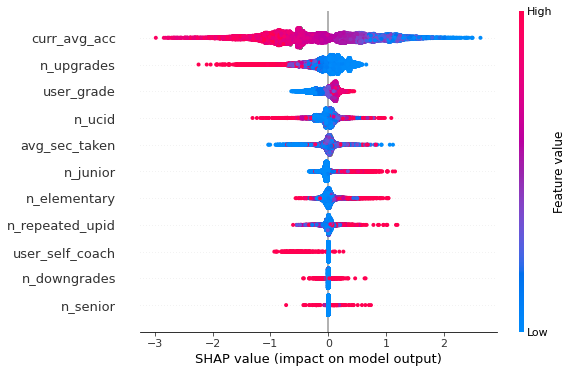

In [48]:
# shap values for each label
for i in range(len(xgb_clf.classes_)):
    print(f'Shap values for class {xgb_clf.classes_[i]}')
    shap.summary_plot(shap_values[i], X_test)

Since features are interpreted as being additive, the outputs are in the log-odds space. 

These plots explain to us how the log-odds of each observvation change based on the feature values. Using the last plot as an example, we can see that high values for *curr_avg_acc* gives observations a lower log-odds of being classified as *weak*. Similar conclusions can be drawn about *n_upgrades*. 

In [52]:
# visualise individual observations' predictions 

def explain_observation(uuid):
    '''
    helper function to get the shap plot for individual observations 
    assume X_test and y_pred are indexed by each students' uuid
    '''
    obs_class = y_pred[uuid]
    obs_class_idx = np.where(xgb_clf.classes_ == obs_class)[0][0]
    int_idx = X_test.index.get_loc(uuid)
    
    # plot
    print(f'predicted class: {obs_class}')
    shap.initjs()
    shap.force_plot(explainer.expected_value[obs_class_idx],
                    shap_values[obs_class_idx][int_idx], X_test.iloc[int_idx, :], 
                    matplotlib=True)

In [58]:
y_pred[y_pred=='weak']

5S54ZbTHNiZsRD0oLq9qhkKM3xtGcxy+tx62+HtlmLc=    weak
0iG3Ay3Hlm4zB+VSCw/CP6xwXYzrlk7Xa213p7Lw7YM=    weak
pBMFSwJ/qE1yX904J94sOTML6BJXDtx4FKffKA06xFE=    weak
RL2hnc1+/H+19umwG7gEFbbFdqfp+Dk4aDazIqJlK4g=    weak
GVMYoKhRwT19FblCUI6aqULhKfKHQsvgWM9N1c0e3yU=    weak
                                                ... 
nZQd2xV4CIhRxocwL/8ixG9PpMaQakGBKWc0693yd1c=    weak
itPeYZ+COBAW87TCMVgSFfpnU69fcGAEA0rOhWdgELA=    weak
f2yfqobduFMjAyFDjzUzMUwQ0DmauYADG/emAxTIsEM=    weak
oIDW7AR80NM6WQFo+oHTjlu/kxJcp7GJV+oUnj+wVfY=    weak
TU5AvGdUZKbdPI3W2zV0lDTPeoK/MGb1iGlANtrX68E=    weak
Name: y_pred, Length: 6287, dtype: object

predicted class: weak


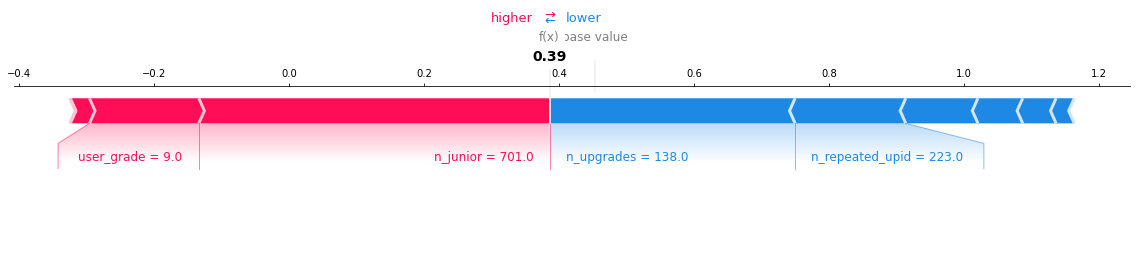

In [60]:
explain_observation('pBMFSwJ/qE1yX904J94sOTML6BJXDtx4FKffKA06xFE=')

We can also analyse individual observations based on the students' ID. 

For this observation, we can see that that the student's average accuracy and number of unique exercises taken caused the log odds of being classified as 'average' to be higher. Similarly, the number of upgrades he obtained caused the log odds to be lower. 

In [50]:
from scipy.special import softmax

# https://stackoverflow.com/questions/65029216/how-to-interpret-base-value-of-multi-class-classification-problem-when-using-sha

softmax(explainer.expected_value)

array([0.35853142, 0.32214075, 0.3193279 ], dtype=float32)

In [51]:
y_pred.value_counts(normalize=True)

strong     0.406831
weak       0.330842
average    0.262327
Name: y_pred, dtype: float64